In [13]:
import os
import numpy as np
import pandas as pd
from time import time
from utils import custom_preprocessing, dependencies

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 26

data_dir = "/home/stavros/DATA/AirbnbReviews"
#data_dir = "D:/"

In [4]:
area = "boston"
area_dir = os.path.join(data_dir, area)

data = pd.read_csv(os.path.join(area_dir, "reviews.csv.gz"))
print(data.shape)

clean_data = data[pd.notnull(data.comments)]
print(clean_data.shape)

(218718, 6)
(218580, 6)


Check how preprocessors work on specific examples (for sanity check)

In [13]:
ind = np.random.randint(0, len(clean_data))

text = clean_data.iloc[ind].comments
print(text)
print()
ptext = custom_preprocessing.preprocessing_pipeline(text)
print(ptext)
print()
features = dependencies.find_features(ptext)
print(features)

Thanks to the Carney family for hosting us. The house was really beautiful and the best part was its proximity to downtown Boston. Made our trip all the more memorable!

Thanks to the Host family for hosting us. The house was really beautiful and the best part was The house proximity to downtown Boston. Made us trip all the more memorable!

{'house', 'part'}


Preprocess multiple reviews (either do this or load already preprocessed reviews from a saved pickle)

In [14]:
n_samples = 2000
n_message = 500

ids = np.arange(len(clean_data))
np.random.shuffle(ids)

sampled_columns = list(clean_data.columns) + ["processed_comments", "word_features"]
sampled_data = pd.DataFrame(index=range(n_samples), columns=sampled_columns)

start_time = time()
i, ic = 0, 0
while ic < n_samples:
    data_row = clean_data.iloc[ids[i]]
    i += 1
    processed_review = custom_preprocessing.preprocessing_pipeline(data_row["comments"])
    
    if processed_review is not None:
        sampled_data.iloc[ic] = data_row
        sampled_data.iloc[ic]["processed_comments"] = processed_review
        sampled_data.iloc[ic]["word_features"] = dependencies.find_features(processed_review)
        ic += 1

    if ic % n_message == 0:
        print("{} / {} found. - time: {}".format(ic + 1, n_samples, time() - start_time))
        
# Save to pickle
sampled_data.to_pickle(os.path.join(area_dir, "reviews_with_word_features_{}samples.pkl".format(n_samples)))

501 / 2000 found. - time: 26.520755529403687
1001 / 2000 found. - time: 50.33985733985901
1501 / 2000 found. - time: 76.03535342216492
2001 / 2000 found. - time: 101.41226363182068


In [4]:
area = "boston"
n_samples = 2000

area_dir = os.path.join(data_dir, area)
sampled_data = pd.read_pickle(os.path.join(area_dir, "reviews_with_word_features_{}samples.pkl".format(n_samples)))

In [5]:
sampled_data

,listing_id,id,date,reviewer_id,reviewer_name,comments,processed_comments,word_features
0,9549850,213510284,2017-11-21,15023148,Dennis,"Gail's basement suite (bedroom, kitchenette/si...",Host basement suite bedroom kitchenette sittin...,"{street, host, variety, hill, food}"
1,18193552,520507608,2019-08-30,248627146,Claudia,Great location in the Seaport District. The co...,Great location in the Seaport District. The co...,"{host, concierge}"
2,28716462,354870110,2018-12-02,225156103,Casey,Good Location. Work out for us!,Good Location. Work out for Good Location!,{}
3,15368927,295434183,2018-07-23,133440138,Jaclyn,"Great location, very private space to stay in!",Great location very private space to stay in!,{}
4,19625919,309055885,2018-08-17,11338797,Kath,Esthers place is as nice as it looks she provi...,Esthers place is as nice as Esthers place look...,"{extras, travellers, esthers place}"
...,...,...,...,...,...,...,...,...
1995,17138041,297303366,2018-07-27,90709502,Lori,The apartment was in a great location. It was ...,The apartment was in a great location. The apa...,"{location, apartment, beds}"
1996,18342681,260372695,2018-05-04,39637463,Molly,This place is great! Super close to the airpor...,This place is great! Super close to the airpor...,"{check, place, touches, work}"
1997,17333246,157768904,2017-06-04,19598336,Danielle,I stayed at this location for a weekend while ...,I stayed at this location for a weekend while ...,"{delays, check, building, walking, host}"
1998,3965492,336747410,2018-10-14,184573774,Pierre,Our stay at May’s was rather nice. Don’t expec...,Our stay at May s was rather nice. Don s expec...,"{room, t, points, pipes, bit, stay}"


Check the features we found

In [6]:
from collections import Counter

all_features = Counter()
for features in sampled_data.word_features:
    for phrase in features:
        for word in phrase.split(" "):
            all_features[word] += 1

In [8]:
print(len(all_features))
print(all_features.most_common(6))

1071
[('host', 538), ('place', 457), ('location', 410), ('apartment', 227), ('stay', 192), ('room', 156)]


In [42]:
def word_barchart(features, n_words=10, n_reviews=None):
    words_bar = [word for word, _ in features.most_common(n_words)]
    if n_reviews is None:
        bar_counts = [count for _, count in features.most_common(n_words)]
    else:
        bar_counts = [count / n_reviews for _, count in features.most_common(n_words)]
    y_pos = [i for i, _ in enumerate(words_bar)]

    plt.figure(figsize=(10, 6))
    cp = sns.color_palette()
    plt.barh(y_pos, bar_counts, color=cp[0])
    plt.yticks(y_pos, words_bar)
    plt.xlabel("Word occurences")
    plt.show()

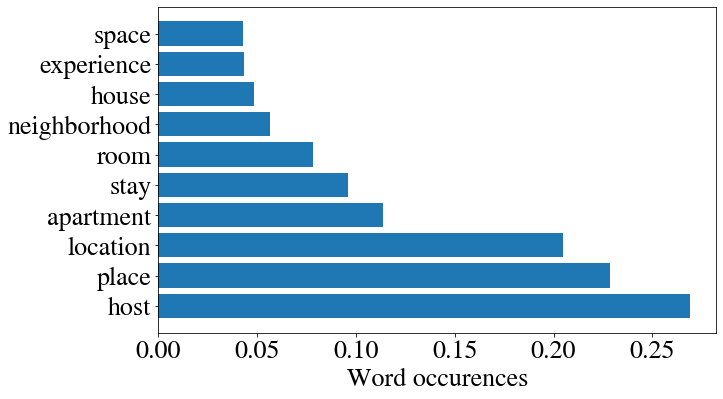

In [43]:
word_barchart(all_features, n_words=10, n_reviews=len(sampled_data))

### Cluster/Visualize the features using word2vec

Check cosine distance values

In [20]:
import gensim
google_vec_file = os.path.join(data_dir, "GoogleNews-vectors-negative300.bin.gz")
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True, limit=200000)
word2vec

In [21]:
words = [word for word, counts in all_features.most_common() if counts > 2 and word in word2vec]
print(len(words))

distance_matrix = np.eye(len(words))
for i, word in enumerate(words):
    for j, word2 in enumerate(words[i:]):
        distance_matrix[i, i + j] = word2vec.distance(word, word2)

275


0.8918886431472036
0.09334183694836762
1.1293818950653076
0.08670997619628906


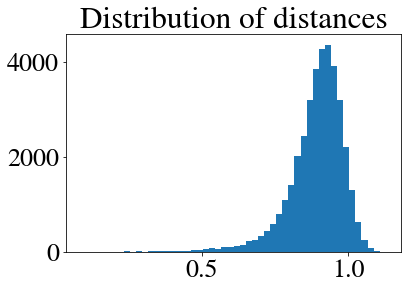

In [22]:
ids = np.triu_indices(len(words), k=1)
print(distance_matrix[ids].mean())
print(distance_matrix[ids].std())
print(distance_matrix[ids].max())
print(distance_matrix[ids].min())

plt.hist(distance_matrix[ids], bins=50)
plt.title("Distribution of distances")
plt.show()

In [25]:
ids = np.triu_indices(len(words), k=1)
cut_offs = [0.1, 0.2, 0.3, 0.4, 0.5]
for cut_off in cut_offs:
    n = (distance_matrix[ids] < cut_off).sum()
    print("Number of words closer than {}: {}".format(cut_off, n))

Number of words closer than 0.1: 1
Number of words closer than 0.2: 4
Number of words closer than 0.3: 29
Number of words closer than 0.4: 71
Number of words closer than 0.5: 190


In [26]:
for i in np.where(distance_matrix[ids] < 0.4)[0]:
    i1, i2 = ids[0][i], ids[1][i]
    print(words[i1], words[i2])

host hosts
location proximity
apartment house
apartment bedroom
apartment condo
room rooms
house bedroom
experience experiences
space spaces
bed beds
area areas
everything things
everything nothing
everything everyone
restaurants restaurant
problem problems
issue issues
bathroom kitchen
bathroom bedroom
bathroom shower
bathroom bathrooms
spot spots
walk walking
it that
issues problems
view views
recommendations recommendation
you we
family friends
bedroom bedrooms
rooms bedrooms
rooms bathrooms
comfy cozy
night nights
pictures photos
things thing
accommodations accommodation
me us
clean cleaning
husband boyfriend
husband wife
husband daughter
we us
day days
responses response
dog cats
dog cat
dog dogs
lots lot
lots plenty
minute minutes
minute hour
restaurant cafe
lot plenty
spacious airy
complaints complaint
anyone everyone
owner owners
smell odor
boyfriend daughter
neighbors neighbor
airy homey
bars bar
cats cat
cats dogs
transportation transport
bedrooms bathrooms
cat dogs
wife daug

Merge words with distance < `cut_off`

In [38]:
removed_words = set()
merged_features = Counter()
cut_off = 0.4

for i, word in enumerate(words):
    if word not in removed_words:
        removed_words.add(word)
        merged_features[word] = all_features[word]
        for j in np.where(distance_matrix[i] < cut_off)[0]:
            if words[j] not in removed_words:
                removed_words.add(words[j])
                merged_features[word] += all_features[words[j]]

print(len(words))
print(len(merged_features))

275
224


In [40]:
merged_features.most_common()

[('host', 618),
 ('place', 457),
 ('location', 413),
 ('apartment', 348),
 ('stay', 192),
 ('room', 172),
 ('bed', 115),
 ('neighborhood', 113),
 ('experience', 94),
 ('bathroom', 92),
 ('space', 90),
 ('everything', 83),
 ('time', 67),
 ('area', 67),
 ('communication', 65),
 ('restaurants', 63),
 ('issue', 62),
 ('home', 58),
 ('problem', 55),
 ('noise', 47),
 ('parking', 41),
 ('spot', 39),
 ('access', 37),
 ('view', 36),
 ('value', 35),
 ('street', 34),
 ('walk', 32),
 ('it', 31),
 ('check', 30),
 ('amenities', 26),
 ('work', 25),
 ('recommendations', 25),
 ('food', 24),
 ('you', 24),
 ('studio', 23),
 ('part', 22),
 ('places', 22),
 ('price', 21),
 ('family', 20),
 ('husband', 20),
 ('breeze', 19),
 ('night', 19),
 ('accommodations', 19),
 ('trouble', 18),
 ('dog', 18),
 ('lots', 18),
 ('people', 17),
 ('comfy', 17),
 ('breakfast', 16),
 ('touches', 16),
 ('pictures', 16),
 ('me', 16),
 ('unit', 15),
 ('top', 15),
 ('trip', 15),
 ('tips', 15),
 ('pleasure', 14),
 ('building', 14),


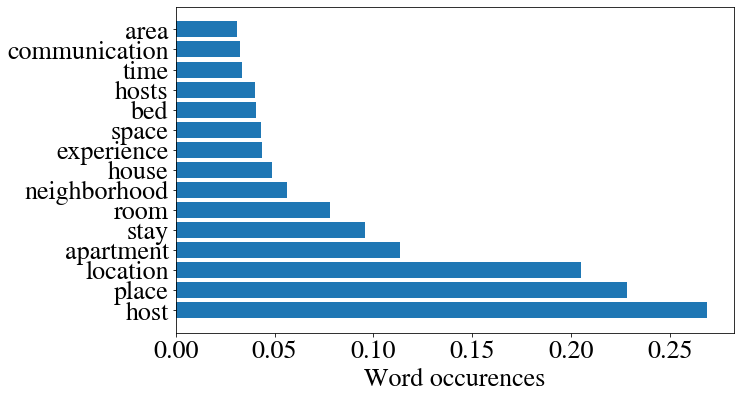

In [50]:
word_barchart(all_features, n_words=15, n_reviews=len(sampled_data))

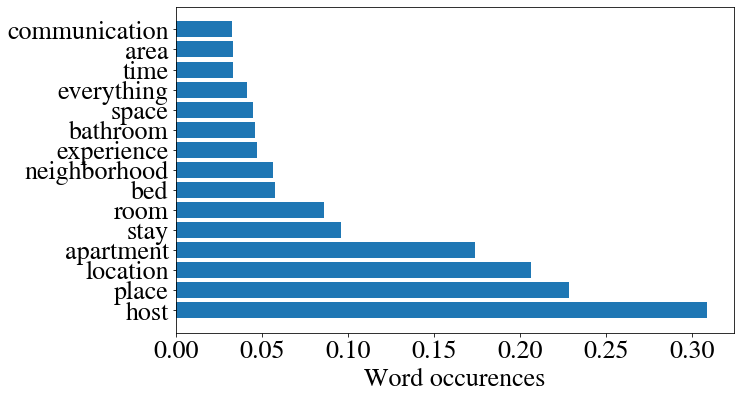

In [49]:
word_barchart(merged_features, n_words=15, n_reviews=len(sampled_data))

### K-Means clustering

In [84]:
from sklearn import cluster

sorted_feature_vecs = np.array([word2vec[word] for word, counts in all_features.most_common()
                                if counts > 2 and word in word2vec])
print(sorted_feature_vecs.shape)
# Normalize
norm = (sorted_feature_vecs**2).sum(axis=-1)
sorted_feature_vecs = sorted_feature_vecs / np.sqrt(norm)[:, np.newaxis]

kmeans = cluster.KMeans(n_clusters=5)
feature_vecs_clustered = kmeans.fit_predict(sorted_feature_vecs)
print(feature_vecs_clustered.shape)

word_clusters = []
for nc in range(kmeans.n_clusters):
    ids = np.where(feature_vecs_clustered == nc)[0]
    word_clusters.append(Counter())
    for i in ids:
        word, count = all_features.most_common()[i]
        word_clusters[-1][word] = count
    
    print("Cluster {}: {} words".format(nc, len(word_clusters[nc])))

(275, 300)
(275,)
Cluster 0: 63 words
Cluster 1: 61 words
Cluster 2: 50 words
Cluster 3: 30 words
Cluster 4: 71 words


In [89]:
word_clusters[4].most_common()

[('experience', 87),
 ('communication', 65),
 ('noise', 47),
 ('access', 37),
 ('value', 35),
 ('view', 22),
 ('neighbourhood', 21),
 ('price', 21),
 ('breakfast', 16),
 ('trip', 15),
 ('tips', 15),
 ('shower', 14),
 ('person', 13),
 ('pictures', 13),
 ('accommodations', 12),
 ('me', 11),
 ('mattress', 10),
 ('air', 10),
 ('ease', 10),
 ('information', 10),
 ('quaint', 8),
 ('gem', 8),
 ('husband', 8),
 ('lady', 8),
 ('option', 8),
 ('listing', 8),
 ('directions', 7),
 ('comfortable', 7),
 ('minute', 7),
 ('shopping', 6),
 ('stylish', 6),
 ('deck', 6),
 ('freedom', 6),
 ('that', 6),
 ('response', 6),
 ('furniture', 6),
 ('weekend', 6),
 ('surprise', 6),
 ('nights', 5),
 ('vibe', 5),
 ('guy', 5),
 ('job', 5),
 ('smell', 5),
 ('environment', 5),
 ('days', 5),
 ('reviews', 5),
 ('cleanliness', 5),
 ('everyone', 4),
 ('conditioning', 4),
 ('welcome', 4),
 ('cats', 4),
 ('couch', 4),
 ('complaint', 4),
 ('recommendation', 4),
 ('which', 4),
 ('ride', 4),
 ('offerings', 3),
 ('city', 3),
 ('

### PCA visualization

In [30]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)
sorted_feature_vecs_pca = pca.fit_transform(sorted_feature_vecs)
print(pca.explained_variance_)

[0.42254725 0.2766825  0.25591326 0.23309138 0.20947953]


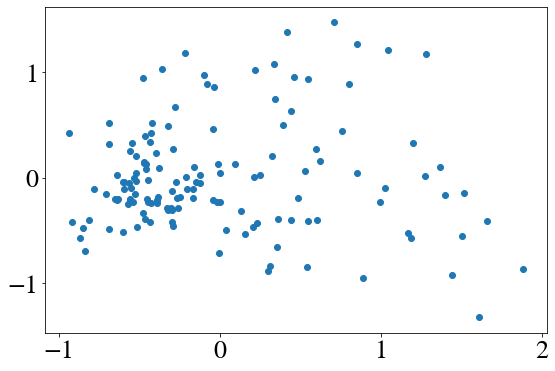

In [32]:
plt.figure(figsize=(9, 6))
plt.scatter(sorted_feature_vecs_pca[:, 0], sorted_feature_vecs_pca[:, 1])
plt.show()